In [1]:
import tensorflow as tf
import keras
import matplotlib.pylab as plt
import numpy as np
import shap
import skimage.io

from keras.preprocessing import image
from skimage.segmentation import slic

print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
print('Notebook running: numpy ', np.__version__)



Notebook running: tensorflow  2.4.1
Notebook running: keras  2.4.3
Notebook running: numpy  1.19.5


It's possible to choose between VGG16, VGG19, MobileNet, InceptionV3(changing the img size) and the AkinolaVGG16. For this experiments ( recognizing chimpanzee, gorilla and white tiger) is the most accurate

In [2]:
#Load pretrained model 

from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
model = tf.keras.models.load_model('..\\data\\model')

# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
# model=VGG16()

# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
# model=VGG19()

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# model=MobileNet()

# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# model=InceptionV3()

In [3]:
model.summary()

Model: "AkinolaVGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

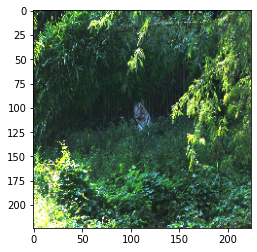

In [4]:
# loading an image

img = tf.keras.preprocessing.image.load_img("image4.jpg", target_size=(224, 224))
# img = tf.keras.preprocessing.image.load_img("image4.jpg", target_size=(299, 299)) #Inception
img_arr = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(img)


skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


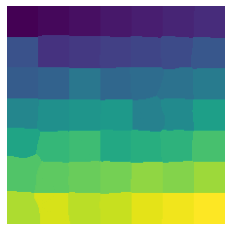

In [5]:
#segmenting the areas

segments_slic = slic(img, n_segments=50, compactness=100, sigma=3)
plt.imshow(segments_slic);
plt.axis('off');

In [6]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    
    return model.predict(preprocess_input((mask_image(z, segments_slic, img_arr))))


<function matplotlib.pyplot.show(close=None, block=None)>

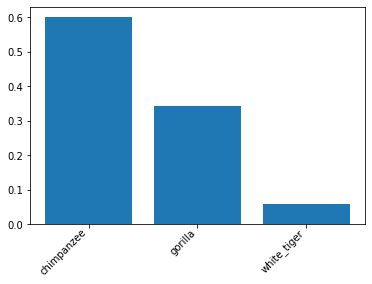

In [7]:
#making prediction
preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),5)
predict=[]
top_preds = np.argsort(-preds)
inds = top_preds[0]

if (model.name=='AkinolaVGG16'):
    class_names={'0':'chimpanzee', '1':'gorilla','2':'white_tiger'}
    preds_data = dict(zip(class_names.values(), preds[0]))
else:
    decoded_preds=decode_predictions(preds,top=10)
    class_names={}
    ind =(-preds[0]).argsort()[:10]
    for i in range (10):
        class_names[str(ind[i])]=decoded_preds[0][i][1]
        predict.append(decoded_preds[0][i][2])
    preds_data = dict(zip(class_names.values(), predict))

#plot results
plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
plt.xticks(range(len(preds_data)), list(preds_data.keys()),rotation=45,va='center_baseline',horizontalalignment='right')
plt.show

In [8]:
# using Kernel SHAP to explain the  predictions

explainer = shap.KernelExplainer(f, np.zeros((1,100)))
    
shap_values = explainer.shap_values(np.ones((1,100)))

100%|██████████| 1/1 [00:56<00:00, 56.06s/it]


In [9]:
# make a color map

from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((87/255,39/255,245/255,l))
for l in np.linspace(0,1,100):
    colors.append((245/255,39/255,87/255,l))  
    
cm = LinearSegmentedColormap.from_list("shap", colors)

In [10]:
# Visualize the explanations

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
    


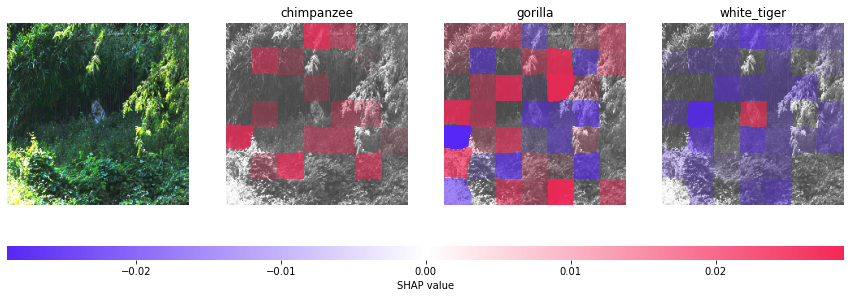

In [11]:
# plot our explanations

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    # if (model.name!='AkinolaVGG16'):
    #     axes[i+1].set_title(class_names[str(i)])
    # else:
    axes[i+1].set_title(class_names[str(inds[i])])
    axes[i+1].imshow(img.convert('LA'),alpha=0.8)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()